In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import re 

import pandas as pd
import numpy as np

import cancerclass as cacl
from cancerclass.pipeline import benchmark_methods
import importlib 
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [22]:
cacl = importlib.reload(cacl)

In [4]:
def rename_colums(colname: str):
    if 'TCGA' in colname:
        return f"TCGA-{re.split('[_|-|.]',colname)[0]}"
    else:
        return colname

def non_cancer_columns(colnames: str):
    return [c for c in colnames if 'TCGA' not in c]

def clean_data(proteome, metadata):
    # Clean columnar data
    proteome.rename(columns=rename_colums, inplace=True)
    proteome.drop(['gene_symbol', 'gene_name'], axis=1, inplace=True)

    metadata = metadata.loc[[x for x in metadata.index.tolist() if x in proteome.columns], :] # Drop patient entries not in proteome dataset
    return proteome,metadata

In [5]:
cancer_proteomes = pd.read_csv('data/77_cancer_proteomes_CPTAC_itraq.csv', header=0, index_col=0)
cancer_metadata  = pd.read_csv('data/clinical_data_breast_cancer.csv',     header=0, index_col=0)
pam50dset        = pd.read_csv('data/PAM50_proteins.csv',                  header=0, index_col=0)

cancer_proteomes,cancer_metadata = clean_data(cancer_proteomes, cancer_metadata)
#filter missing value threshold 0.5
cancer_proteomes = cacl.utils.filter_by_missingness(cancer_proteomes, threshold=0.5)
cancer_proteomes.head()

[Preprocessing] Original proteins: 12553
[Preprocessing] Kept proteins:     11522
[Preprocessing] Dropped:           1031


,TCGA-AO-A12D,TCGA-C8-A131,TCGA-AO-A12B,TCGA-BH-A18Q,TCGA-C8-A130,TCGA-C8-A138,TCGA-E2-A154,TCGA-C8-A12L,TCGA-A2-A0EX,TCGA-AO-A12D,...,TCGA-AO-A12B,TCGA-A2-A0SW,TCGA-AO-A0JL,TCGA-BH-A0BV,TCGA-A2-A0YM,TCGA-BH-A0C7,TCGA-A2-A0SX,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,1.185108,1.100688,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,1.192612,1.100688,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,1.188860,1.100688,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,1.185108,1.100688,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,1.200116,1.093358,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [6]:
cancer_metadata.head()

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-A7-A0CE,FEMALE,57,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2
TCGA-D8-A142,FEMALE,74,Negative,Negative,Negative,T3,T_Other,N0,Negative,M0,...,Basal-like,0,-13,3,5,X,1,2,2,2
TCGA-AO-A0J6,FEMALE,61,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,2,5,Basal,1,2,2,2


In [7]:
cancer_proteomes = cancer_proteomes.T.merge(pd.DataFrame(cancer_metadata['PAM50 mRNA']), left_index=True, right_index=True, how='left')
cancer_proteomes.iloc[-3:,-1] = ["Non-cancer"] * 3

labels = cancer_proteomes.iloc[:,-1]
encoded_labels = cacl.ohe_data(labels)

data = cancer_proteomes.iloc[:,:-1].to_numpy()
cancer_proteomes.T.tail()

/home2/s440865/.conda/envs/cancerclass/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,TCGA-AO-A12D,TCGA-C8-A131,TCGA-AO-A12B,TCGA-BH-A18Q,TCGA-C8-A130,TCGA-C8-A138,TCGA-E2-A154,TCGA-C8-A12L,TCGA-A2-A0EX,TCGA-AO-A12D,...,TCGA-AO-A12B,TCGA-A2-A0SW,TCGA-AO-A0JL,TCGA-BH-A0BV,TCGA-A2-A0YM,TCGA-BH-A0C7,TCGA-A2-A0SX,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
NP_001193600,NaN,NaN,NaN,0.048144,1.457462,-3.250913,-3.386203,-0.5033,1.45149,NaN,...,NaN,0.59607,-4.539976,-1.086936,NaN,NaN,NaN,-2.162522,-4.357763,-1.543779
NP_061134,NaN,NaN,NaN,NaN,NaN,1.711825,-2.328692,-2.153722,-2.018981,NaN,...,-0.749784,0.969143,0.860356,2.128858,NaN,NaN,NaN,1.520756,-2.386605,0.518115
NP_003593,-0.340163,3.451902,-1.718531,2.527072,0.296389,NaN,NaN,NaN,NaN,0.129501,...,-0.447161,-1.053815,-1.202445,-1.219546,NaN,NaN,NaN,NaN,NaN,NaN
NP_001191293,NaN,NaN,NaN,-16.029761,1.729692,4.107251,-9.584499,-5.196859,-6.101005,-2.578828,...,-6.66235,NaN,NaN,NaN,NaN,NaN,NaN,-8.020071,-3.093822,-4.602418
PAM50 mRNA,HER2-enriched,Basal-like,Luminal B,Basal-like,HER2-enriched,HER2-enriched,Luminal A,HER2-enriched,Luminal A,HER2-enriched,...,Luminal B,Luminal B,Basal-like,Luminal A,Basal-like,Luminal B,Basal-like,Non-cancer,Non-cancer,Non-cancer


/home2/s440865/.conda/envs/cancerclass/lib/python3.13/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


   [DreamAI] Running Ensemble on shape (66, 11522)...
   Running Variational Autoencoder (VAE)...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

   [DreamAI] Running Ensemble on shape (66, 11522)...
   Running Variational Autoencoder (VAE)...
   [DreamAI] Running Ensemble on shape (17, 11522)...
   Running Variational Autoencoder (VAE)...
   [DreamAI] Running Ensemble on shape (66, 11522)...
   Running Variational Autoencoder (VAE)...
   [DreamAI] Running Ensemble on shape (17, 11522)...
   Running Variational Autoencoder (VAE)...


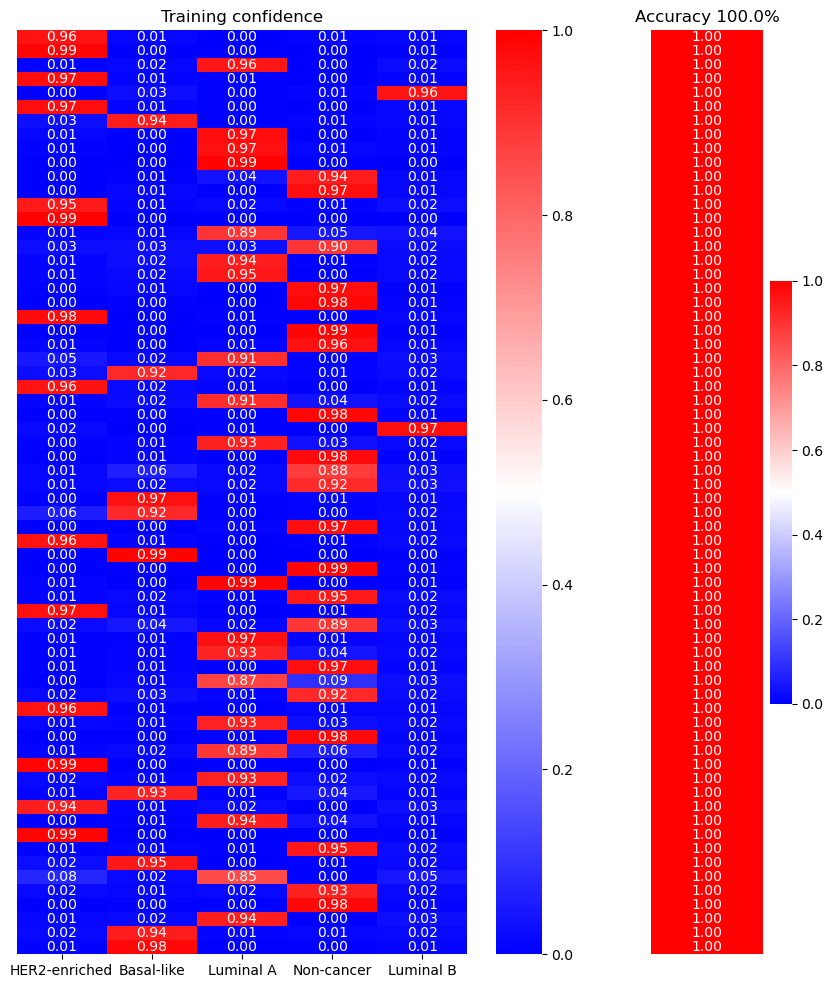

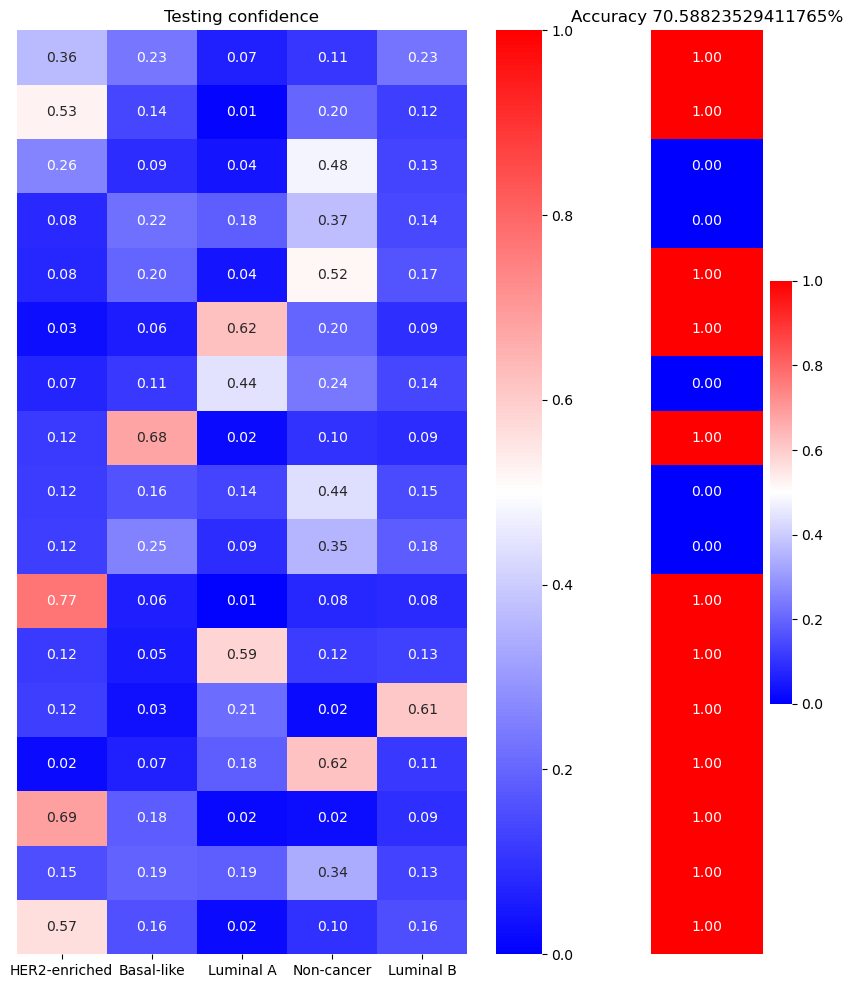

In [9]:
X_train,X_test,Y_train,Y_test = train_test_split(data, encoded_labels, train_size=0.8, shuffle=True)

model = cacl.train_pipeline(
                            X_train,
                            Y_train, 
                            preprocessing_step='standard', 
                            imputation_type='dream', 
                            classifier='bayeslog', 
                            )
cacl.analysis_pipeline(model, (X_train,X_test,Y_train,Y_test), labels)

In [11]:
df_results = benchmark_methods(
    X_train, Y_train, 
    X_test, Y_test, 
    methods=['mean', 'mice','dream']
)

Running Benchmark on methods: ['mean', 'mice', 'dream']...


ValueError: Input contains NaN.

/home2/s440865/.conda/envs/cancerclass/lib/python3.13/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


   [DreamAI] Running Ensemble on shape (66, 11522)...
   Running Variational Autoencoder (VAE)...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


   [DreamAI] Running Ensemble on shape (66, 11522)...
   Running Variational Autoencoder (VAE)...
   [DreamAI] Running Ensemble on shape (17, 11522)...
   Running Variational Autoencoder (VAE)...
   [DreamAI] Running Ensemble on shape (66, 11522)...
   Running Variational Autoencoder (VAE)...
   [DreamAI] Running Ensemble on shape (17, 11522)...
   Running Variational Autoencoder (VAE)...


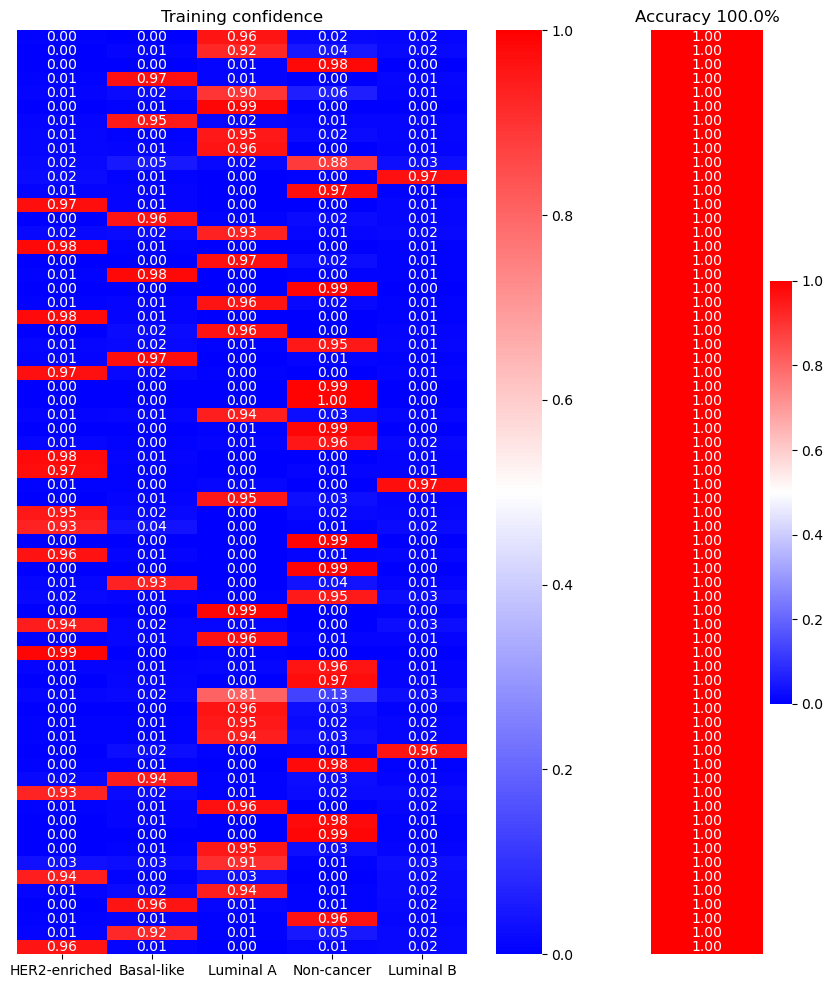

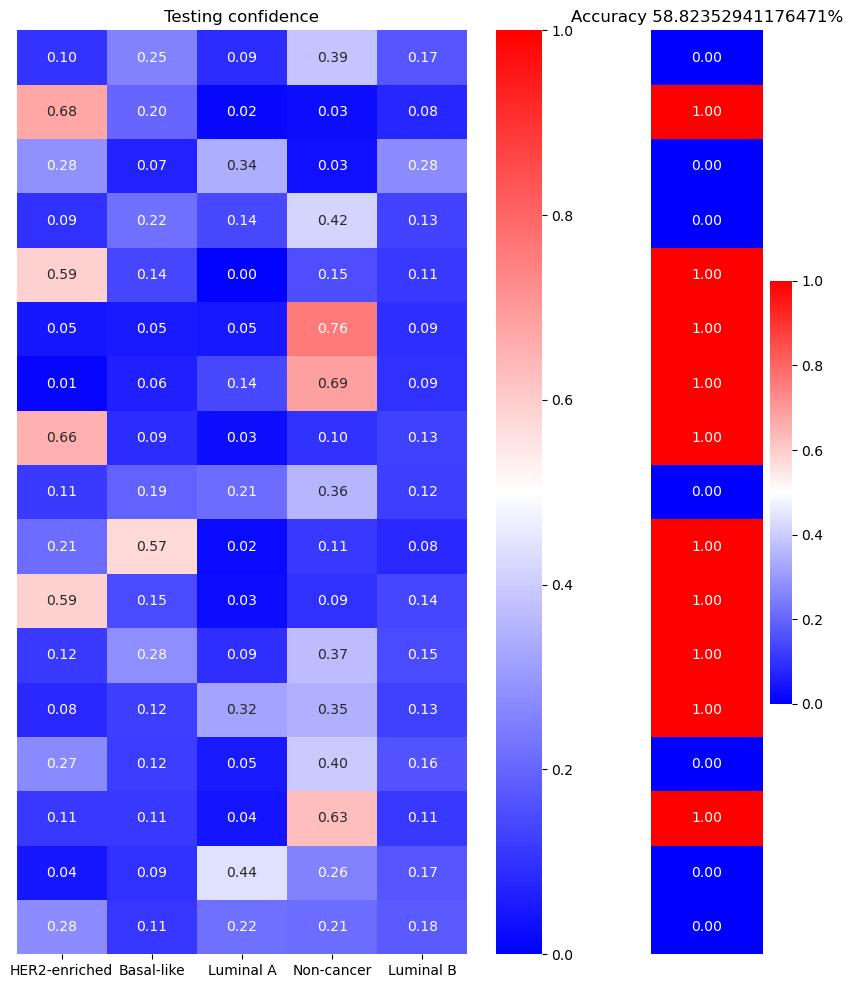

In [27]:
pam50_proteome = cancer_proteomes[[p for p in pam50dset['RefSeqProteinID'] if p in cancer_proteomes.columns]]

pX_train,pX_test,pY_train,pY_test = train_test_split(data, encoded_labels, train_size=0.8, shuffle=True)

pam_model = cacl.train_pipeline(
                            pX_train, 
                            pY_train, 
                            preprocessing_step='standard',
                            imputation_type='dream',
                            classifier='bayeslog',
                            weight_prior='laplace',
                            intercept_prior='laplace'
                            )
cacl.analysis_pipeline(pam_model, (pX_train,pX_test,pY_train,pY_test), labels)

In [26]:
df_method, confusion_matrices = cacl.benchmark_classification(pX_train, pY_train, pX_test, pY_test, imputation_type='dream')

Running Benchmark on methods: ['naivebayes', 'logistic', 'bayeslog', 'svm']...


/home2/s440865/.conda/envs/cancerclass/lib/python3.13/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


   [DreamAI] Running Ensemble on shape (66, 11522)...
   Running Variational Autoencoder (VAE)...
   [DreamAI] Running Ensemble on shape (17, 11522)...
   Running Variational Autoencoder (VAE)...
Pre-imputation done
Running naivebayes...
Running logistic...


/home2/s440865/.conda/envs/cancerclass/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home2/s440865/.conda/envs/cancerclass/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home2/s440865/.conda/envs/cancerclass/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iterat

Running bayeslog...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Running svm...
            Classification F1  Test accuracy  Train accuracy
Method                                                      
NAIVEBAYES           0.615313       0.588235        0.878788
LOGISTIC             0.821747       0.823529        1.000000
BAYESLOG             0.645780       0.647059        1.000000
SVM                  0.668908       0.647059        1.000000


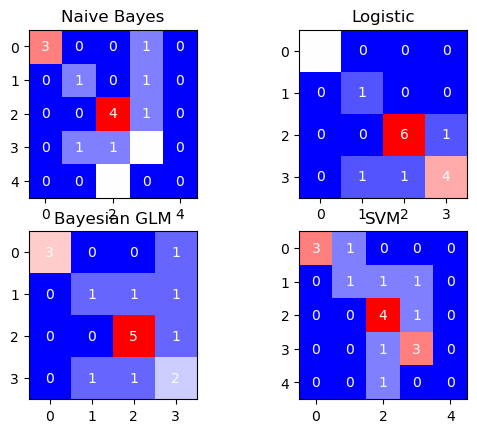

In [ ]:
for i,name in enumerate(['Naive Bayes', 'Logistic', 'Bayesian GLM', 'SVM']):
    plt.subplot(220 + i + 1)
    plt.title(name)
    cacl.plot_heatmap(plt.gca(), confusion_matrices[i]['Test Confusion'], vmin=None, vmax=None)